In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlretrieve


In [2]:
def load_spambase_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
    try:
       
        urlretrieve(url, "spambase.data")
        
        features = [
            
            *[f'word_freq_{i}' for i in range(48)],
            
            *[f'char_freq_{i}' for i in range(6)],
            
            'capital_run_length_average',
            'capital_run_length_longest',
            'capital_run_length_total',
            #
            'is_spam'
        ]
        
        
        data = pd.read_csv("spambase.data", names=features)
        
        
        X = data.drop('is_spam', axis=1)
        y = data['is_spam']
        
        return X, y
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

Model Accuracy: 91.97%

Classification Report:
              precision    recall  f1-score   support

    Non-Spam       0.91      0.95      0.93       531
        Spam       0.93      0.87      0.90       390

    accuracy                           0.92       921
   macro avg       0.92      0.91      0.92       921
weighted avg       0.92      0.92      0.92       921


Top 10 Most Important Features:
         Feature  Importance
26  word_freq_26    4.472549
24  word_freq_24    2.796473
40  word_freq_40    1.686775
43  word_freq_43    1.481782
41  word_freq_41    1.281441
52   char_freq_4    1.233956
45  word_freq_45    1.155771
47  word_freq_47    1.017711
28  word_freq_28    0.991178
22  word_freq_22    0.984019


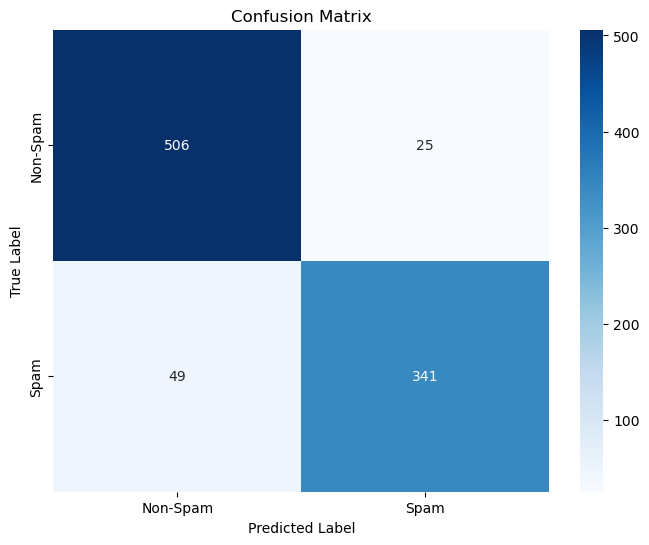

In [3]:
def train_spam_classifier():
    X, y = load_spambase_data()
    
    if X is None or y is None:
        raise Exception("Failed to load dataset")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    
    report = classification_report(y_test, y_pred, target_names=['Non-Spam', 'Spam'])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Spam', 'Spam'],
                yticklabels=['Non-Spam', 'Spam'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': abs(model.coef_[0])
    }).sort_values('Importance', ascending=False).head(10)
    
    return {
        'model': model,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'feature_importance': feature_importance,
        'scaler': scaler,
        'features': X.columns
    }

results = train_spam_classifier()

print(f"Model Accuracy: {results['accuracy']:.2%}")
print("\nClassification Report:")
print(results['classification_report'])
print("\nTop 10 Most Important Features:")
print(results['feature_importance'])

In [4]:
def predict_spam(model, scaler, email_features, feature_names):
    """
    Predict if an email is spam based on its features
    
    Parameters:
    email_features: dict with values for all required features
    """
    
    features_df = pd.DataFrame([email_features], columns=feature_names)
    
    scaled_features = scaler.transform(features_df)
    
    prediction = model.predict(scaled_features)[0]
    probability = model.predict_proba(scaled_features)[0]
    
    return {
        'is_spam': bool(prediction),
        'spam_probability': probability[1]
    }

example_email = dict(zip(results['features'], np.zeros(len(results['features']))))
example_email['word_freq_0'] = 0.3  
example_email['char_freq_0'] = 0.1  
example_email['capital_run_length_average'] = 2.5

prediction = predict_spam(
    results['model'], 
    results['scaler'], 
    example_email,
    results['features']
)
print("\nExample Prediction:")
print(f"Is Spam: {prediction['is_spam']}")
print(f"Spam Probability: {prediction['spam_probability']:.2%}")


Example Prediction:
Is Spam: False
Spam Probability: 14.82%
